In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="gH4DnlLg4Gi5fnlGzCMa")
project = rf.workspace("industrialaicapstone").project("capstone_project-iwcq5")
version = project.version(11)
dataset = version.download("yolov5")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to capstone_project-11 in yolov5pytorch:: 100%|██████████| 4012/4012 [00:00<00:00, 6781.89it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================
# STEP 1) 카메라11 Original vs Enhanced_3rd
#        동일 분할(600/75/75) 파일리스트 + YAML 자동 생성
# ============================================
import os, random, textwrap

# 경로 설정
BASE = "/content/drive/MyDrive/camera_split/camera_11"
ORIG = os.path.join(BASE, "images")
ENH  = os.path.join(BASE, "enhanced_3rd")

OUT_DIR = "/content/cam11_yaml"  # 생성물 저장 폴더
os.makedirs(OUT_DIR, exist_ok=True)

# 이미지 확장자
EXTS = (".jpg",".jpeg",".png",".bmp")

# 1) 파일 수집 (원본 기준)
files = [f for f in os.listdir(ORIG) if f.lower().endswith(EXTS)]
files.sort()
assert len(files) >= 750, f"이미지 수가 750 미만입니다: {len(files)}"

# 2) 보강 폴더 교집합
common = [f for f in files if os.path.exists(os.path.join(ENH, f))]
print(f"공통 파일 개수: {len(common)}")

# 3) 고정 분할(600/75/75)
random.seed(42)
random.shuffle(common)
train_files = common[:600]
val_files   = common[600:675]
test_files  = common[675:750]

def write_list(txt_path, base_dir, names):
    with open(txt_path, "w") as f:
        for n in names:
            f.write(os.path.join(base_dir, n) + "\n")

# 리스트 파일 저장
orig_train = os.path.join(OUT_DIR, "cam11_orig_train.txt")
orig_val   = os.path.join(OUT_DIR, "cam11_orig_val.txt")
orig_test  = os.path.join(OUT_DIR, "cam11_orig_test.txt")

enh_train  = os.path.join(OUT_DIR, "cam11_enh_train.txt")
enh_val    = os.path.join(OUT_DIR, "cam11_enh_val.txt")
enh_test   = os.path.join(OUT_DIR, "cam11_enh_test.txt")

write_list(orig_train, ORIG, train_files)
write_list(orig_val,   ORIG, val_files)
write_list(orig_test,  ORIG, test_files)

write_list(enh_train, ENH, train_files)
write_list(enh_val,   ENH, val_files)
write_list(enh_test,  ENH, test_files)

print("✅ 리스트 파일 생성 완료")


공통 파일 개수: 750
✅ 리스트 파일 생성 완료


In [ ]:
import os, textwrap

OUT_DIR = "/content/cam11_yaml"

yaml_orig = os.path.join(OUT_DIR, "data_cam11_original.yaml")
yaml_enh  = os.path.join(OUT_DIR, "data_cam11_enhanced.yaml")

orig_train = os.path.join(OUT_DIR, "cam11_orig_train.txt")
orig_val   = os.path.join(OUT_DIR, "cam11_orig_val.txt")
orig_test  = os.path.join(OUT_DIR, "cam11_orig_test.txt")
enh_train  = os.path.join(OUT_DIR, "cam11_enh_train.txt")
enh_val    = os.path.join(OUT_DIR, "cam11_enh_val.txt")
enh_test   = os.path.join(OUT_DIR, "cam11_enh_test.txt")

assert os.path.exists(orig_train) and os.path.exists(enh_train), "리스트 파일이 없습니다. Step 1 먼저 실행하세요."

names = ["gown_on", "hairnet_on", "person"]  # ✅ 실제 클래스명

with open(yaml_orig, "w") as f:
    f.write(textwrap.dedent(f"""
    # Camera 11 - Original
    train: {orig_train}
    val: {orig_val}
    test: {orig_test}
    nc: {len(names)}
    names: {names}
    """).strip()+"\n")

with open(yaml_enh, "w") as f:
    f.write(textwrap.dedent(f"""
    # Camera 11 - Enhanced_3rd
    train: {enh_train}
    val: {enh_val}
    test: {enh_test}
    nc: {len(names)}
    names: {names}
    """).strip()+"\n")

print("✅ YAML 업데이트 완료")


✅ YAML 업데이트 완료


In [ ]:
# =========================================================
# Camera 11 - Original 전용 학습 (W&B OFF, Drive에 저장)
# =========================================================
from google.colab import drive
drive.mount('/content/drive')  # ⬅ 이미 마운트돼 있어도 안전

import os, shutil, sys
from datetime import datetime

# 1) W&B 완전 비활성화 (팝업 방지)
os.environ["WANDB_MODE"] = "disabled"

# 2) 작업 디렉토리 정리 및 YOLOv5 설치
os.makedirs("/content", exist_ok=True)
os.chdir("/content")
if os.path.exists("/content/yolov5"):
    shutil.rmtree("/content/yolov5", ignore_errors=True)

!git clone -q --depth 1 https://github.com/ultralytics/yolov5 /content/yolov5
!pip install -q -r /content/yolov5/requirements.txt

import torch
print(f"✅ YOLOv5 ready | torch {torch.__version__}")

# 3) 경로 설정
YAML_ORIG = "/content/cam11_yaml/data_cam11_original.yaml"  # ← Step1에서 만든 YAML
assert os.path.exists(YAML_ORIG), f"YAML 없음: {YAML_ORIG}"

STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
PROJECT_DIR = f"/content/drive/MyDrive/yolo_results_cam11/orig_{STAMP}"  # 드라이브에 저장
os.makedirs(PROJECT_DIR, exist_ok=True)
print("📂 결과 저장 경로:", PROJECT_DIR)

# 4) 학습 실행 (원본만)
#  - epochs/batch는 필요에 맞게 조정 가능
#  - 조기종료(--patience)로 과적합 방지
!python /content/yolov5/train.py --img 640 --epochs 100 --batch 16 \
  --data {YAML_ORIG} \
  --weights yolov5n.pt \
  --name cam11_O_train --seed 42 --patience 15 \
  --project {PROJECT_DIR}

print("\n✅ DONE: Original 학습 완료")
print("   ➤ best.pt :", f"{PROJECT_DIR}/cam11_O_train/weights/best.pt")
print("   ➤ curves  :", f"{PROJECT_DIR}/cam11_O_train/results.png  (P/R/mAP 곡선)")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  with torch.cuda.amp.autocast(amp):
      38/99      2.22G    0.05048    0.02518    0.01436        165        640:  50% 19/38 [00:01<00:01, 10.24it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      38/99      2.22G    0.05031    0.02477    0.01439        107        640:  55% 21/38 [00:02<00:01,  9.98it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      38/99      2.22G     0.0508    0.02466    0.01459        162        640:  55% 21/38 [00:02<00:01,  9.98it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      38/99    

In [ ]:
import os

# 카메라 11 폴더 경로
camera11_path = "/content/drive/MyDrive/camera_split/camera_11"

# 하위 구조 확인
for root, dirs, files in os.walk(camera11_path):
    print(f"📂 {root}")
    img_count = len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    lbl_count = len([f for f in files if f.lower().endswith('.txt')])
    if img_count > 0 or lbl_count > 0:
        print(f"  → 이미지 {img_count}개, 라벨 {lbl_count}개")


📂 /content/drive/MyDrive/camera_split/camera_11
📂 /content/drive/MyDrive/camera_split/camera_11/images
  → 이미지 750개, 라벨 0개
📂 /content/drive/MyDrive/camera_split/camera_11/labels
  → 이미지 0개, 라벨 750개
📂 /content/drive/MyDrive/camera_split/camera_11/enhanced_3rd
  → 이미지 750개, 라벨 750개


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 원본 데이터 경로 (보강된 데이터셋)
src_img_dir = "/content/drive/MyDrive/camera_split/camera_11/enhanced_3rd"
src_label_dir = "/content/drive/MyDrive/camera_split/camera_11/enhanced_3rd"

# 저장 경로
dst_root = "/content/drive/MyDrive/camera11_augmented_dataset"
splits = ["train", "valid", "test"]

# 이미지/라벨 파일 리스트
images = [f for f in os.listdir(src_img_dir) if f.endswith(".jpg")]
labels = [f for f in os.listdir(src_label_dir) if f.endswith(".txt")]

# 이미지-라벨 매칭 (확실히 페어링되도록)
images.sort()
labels.sort()

# train/valid/test 분할
train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

split_map = {
    "train": train_imgs,
    "valid": valid_imgs,
    "test": test_imgs,
}

# 폴더 생성 및 복사
for split in splits:
    img_dst = os.path.join(dst_root, split, "images")
    lbl_dst = os.path.join(dst_root, split, "labels")
    os.makedirs(img_dst, exist_ok=True)
    os.makedirs(lbl_dst, exist_ok=True)

    for img_file in split_map[split]:
        # 이미지 복사
        shutil.copy2(os.path.join(src_img_dir, img_file), os.path.join(img_dst, img_file))

        # 라벨 파일 복사
        label_file = img_file.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(src_label_dir, label_file)):
            shutil.copy2(os.path.join(src_label_dir, label_file), os.path.join(lbl_dst, label_file))

print("✅ Dataset split 완료: train/valid/test 이미지 및 라벨 저장됨")


✅ Dataset split 완료: train/valid/test 이미지 및 라벨 저장됨


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 원본 이미지/라벨 경로
src_img_dir = "/content/drive/MyDrive/camera_split/camera_11/images"
src_label_dir = "/content/drive/MyDrive/camera_split/camera_11/labels"

# 보강 버전들 (여기서 enhanced_3rd 를 시작점으로 복사)
src_aug_dir = "/content/drive/MyDrive/camera_split/camera_11/enhanced_3rd"

# 저장 경로
dst_root = "/content/drive/MyDrive/camera11_augmented_experiment"

# 실험할 폴더 이름들
exp_list = ["Baseline", "BrightnessContrast", "CLAHE", "Sharpen"]

# 이미지/라벨 확장자
exts = (".jpg", ".png")

# train/valid/test 비율
train_ratio, valid_ratio, test_ratio = 0.8, 0.1, 0.1

# 원본 이미지 리스트
images = [f for f in os.listdir(src_img_dir) if f.lower().endswith(exts)]
images.sort()

# train/valid/test split
train_imgs, temp_imgs = train_test_split(images, test_size=(1-train_ratio), random_state=42)
valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

splits = {
    "train": train_imgs,
    "valid": valid_imgs,
    "test": test_imgs
}

# 보강 기법별 데이터셋 생성
for exp in exp_list:
    for split, split_files in splits.items():
        # 폴더 생성
        dst_img_dir = os.path.join(dst_root, exp, split, "images")
        dst_label_dir = os.path.join(dst_root, exp, split, "labels")
        os.makedirs(dst_img_dir, exist_ok=True)
        os.makedirs(dst_label_dir, exist_ok=True)

        # 파일 복사
        for file in split_files:
            if exp == "Baseline":
                img_src = os.path.join(src_img_dir, file)
            else:
                img_src = os.path.join(src_aug_dir, file)

            label_src = os.path.join(src_label_dir, file.replace(".jpg", ".txt").replace(".png", ".txt"))

            img_dst = os.path.join(dst_img_dir, file)
            label_dst = os.path.join(dst_label_dir, os.path.basename(label_src))

            if os.path.exists(img_src):
                shutil.copy2(img_src, img_dst)
            if os.path.exists(label_src):
                shutil.copy2(label_src, label_dst)

print("✅ 보강 폴더별 이미지/라벨 복사 완료")


✅ 보강 폴더별 이미지/라벨 복사 완료


In [ ]:
import os

# 경로
base_dir = "/content/drive/MyDrive/camera11_augmented_experiment"
exp_list = ["Baseline", "BrightnessContrast", "CLAHE", "Sharpen"]
splits = ["train", "valid", "test"]

ext_img = (".jpg", ".png")
ext_label = (".txt",)

summary = {}

for exp in exp_list:
    summary[exp] = {}
    for split in splits:
        img_dir = os.path.join(base_dir, exp, split, "images")
        label_dir = os.path.join(base_dir, exp, split, "labels")

        n_imgs = len([f for f in os.listdir(img_dir) if f.lower().endswith(ext_img)]) if os.path.exists(img_dir) else 0
        n_labels = len([f for f in os.listdir(label_dir) if f.lower().endswith(ext_label)]) if os.path.exists(label_dir) else 0

        summary[exp][split] = (n_imgs, n_labels)

# 결과 출력
print("📊 보강 실험 데이터셋 요약")
for exp, splits_data in summary.items():
    print(f"\n[{exp}]")
    for split, (n_imgs, n_labels) in splits_data.items():
        print(f"  {split}: {n_imgs} images, {n_labels} labels")


📊 보강 실험 데이터셋 요약

[Baseline]
  train: 600 images, 600 labels
  valid: 75 images, 75 labels
  test: 75 images, 75 labels

[BrightnessContrast]
  train: 600 images, 600 labels
  valid: 75 images, 75 labels
  test: 75 images, 75 labels

[CLAHE]
  train: 600 images, 600 labels
  valid: 75 images, 75 labels
  test: 75 images, 75 labels

[Sharpen]
  train: 600 images, 600 labels
  valid: 75 images, 75 labels
  test: 75 images, 75 labels


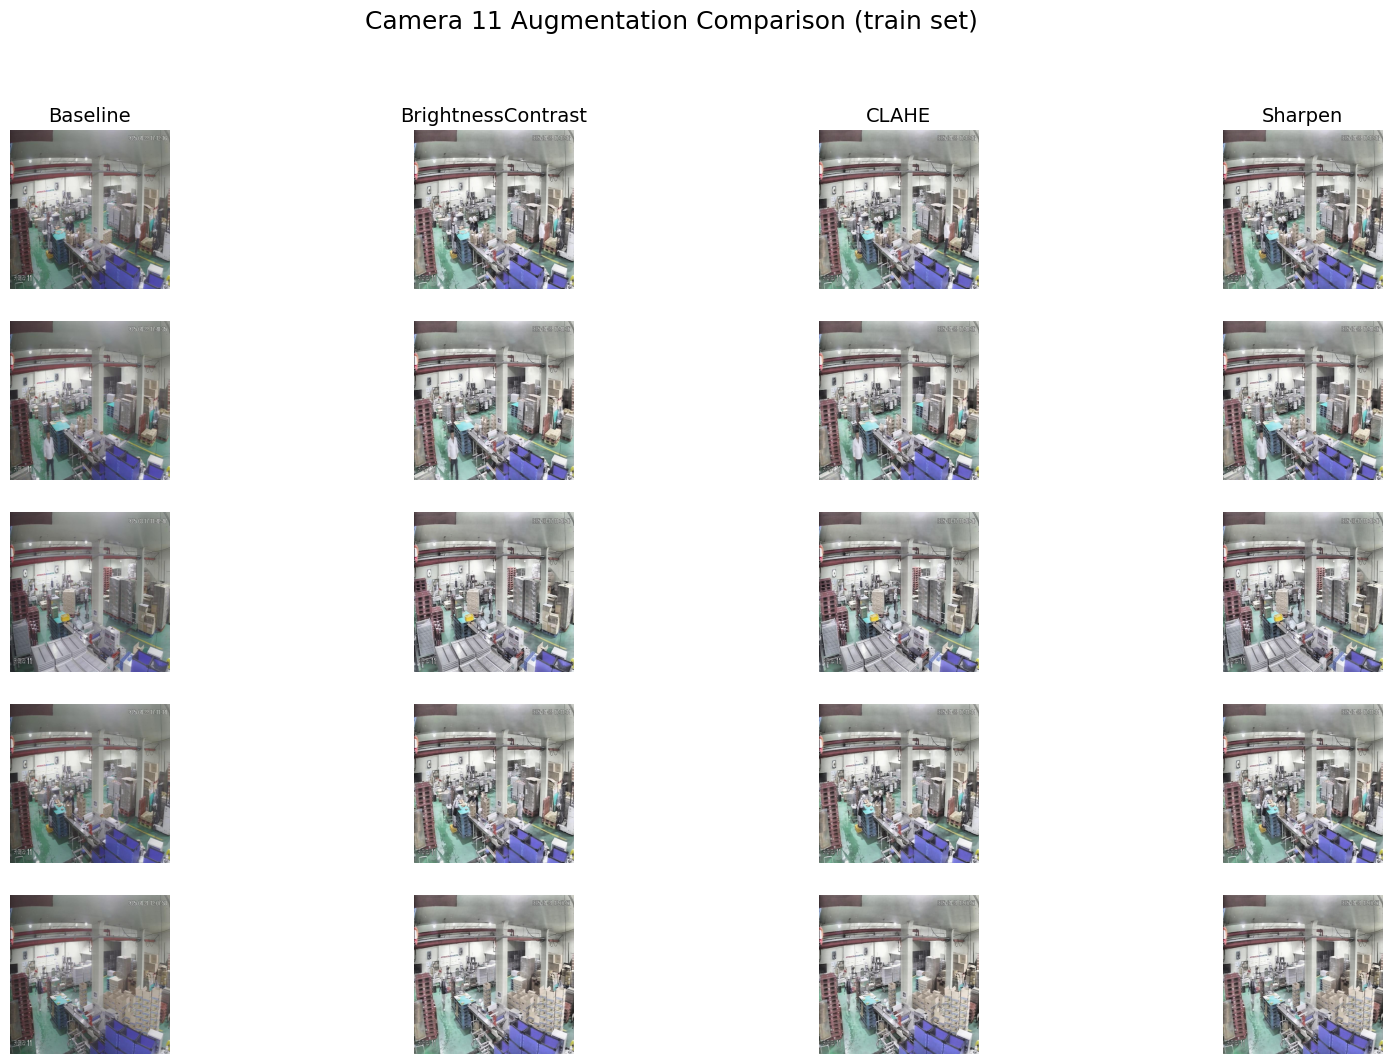

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

base_dir = "/content/drive/MyDrive/camera11_augmented_experiment"
exp_list = ["Baseline", "BrightnessContrast", "CLAHE", "Sharpen"]

# train 이미지에서 5개 랜덤 샘플 선택
sample_files = random.sample(os.listdir(os.path.join(base_dir, "Baseline/train/images")), 5)

# 시각화
plt.figure(figsize=(20, 12))

for i, file in enumerate(sample_files):
    for j, exp in enumerate(exp_list):
        img_path = os.path.join(base_dir, exp, "train/images", file)
        if not os.path.exists(img_path):
            continue
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(5, len(exp_list), i*len(exp_list) + j + 1)
        plt.imshow(img)
        plt.axis("off")
        if i == 0:  # 첫 행에만 라벨
            plt.title(exp, fontsize=14)

plt.suptitle("Camera 11 Augmentation Comparison (train set)", fontsize=18)
plt.show()


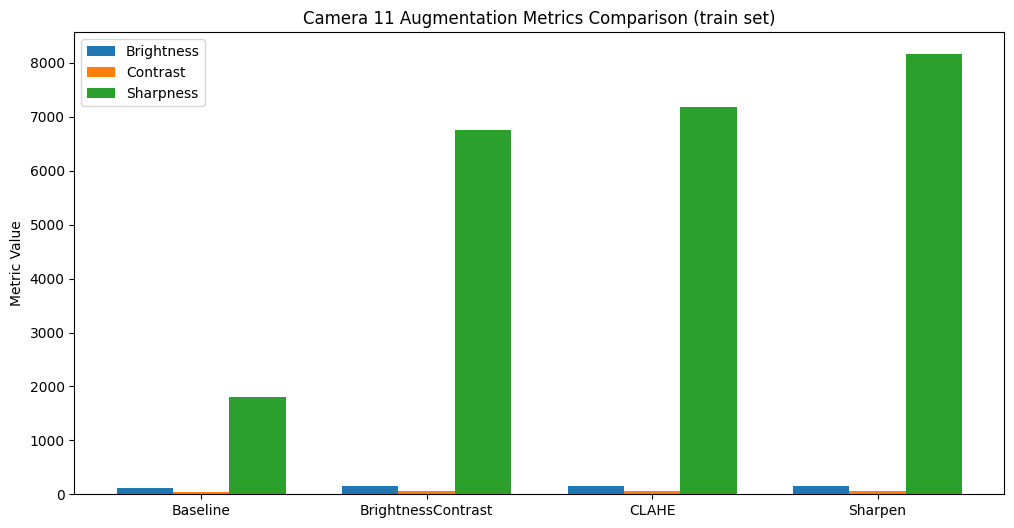

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# ✅ 올바른 최상위 경로
base_dir = "/content/drive/MyDrive/camera11_augmented_experiment"

# 실험 폴더들
folders = {
    "Baseline": os.path.join(base_dir, "Baseline/train/images"),
    "BrightnessContrast": os.path.join(base_dir, "BrightnessContrast/train/images"),
    "CLAHE": os.path.join(base_dir, "CLAHE/train/images"),
    "Sharpen": os.path.join(base_dir, "Sharpen/train/images"),
}

def analyze_images(image_paths):
    brightness, contrast, sharpness = [], [], []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        brightness.append(np.mean(img))
        contrast.append(np.std(img))
        laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
        sharpness.append(laplacian_var)
    return np.mean(brightness), np.mean(contrast), np.mean(sharpness)

# 📊 결과 저장
results = {}

for name, folder in folders.items():
    all_files = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png"))]
    sample_files = random.sample(all_files, min(50, len(all_files)))  # 최대 50장 샘플
    paths = [os.path.join(folder, f) for f in sample_files]
    results[name] = analyze_images(paths)

# 그래프로 시각화
labels = list(results.keys())
brightness = [results[k][0] for k in labels]
contrast = [results[k][1] for k in labels]
sharpness = [results[k][2] for k in labels]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, brightness, width, label="Brightness")
plt.bar(x, contrast, width, label="Contrast")
plt.bar(x + width, sharpness, width, label="Sharpness")
plt.xticks(x, labels)
plt.ylabel("Metric Value")
plt.title("Camera 11 Augmentation Metrics Comparison (train set)")
plt.legend()
plt.show()


In [ ]:
# ============================================
# STEP 1) Camera 11 안전 보강 v4 생성
#  - 입력:  /content/drive/MyDrive/camera_split/camera_11/images
#  - 출력:  /content/drive/MyDrive/camera_split/camera_11/enhanced_4th
#  - 핵심: denoise/샤프닝 완화 + 어두운 장면만 감마 보정
# ============================================
import os, cv2, numpy as np
from tqdm import tqdm

BASE = "/content/drive/MyDrive/camera_split/camera_11"
SRC_DIR = os.path.join(BASE, "images")          # 원본 이미지
DST_DIR = os.path.join(BASE, "enhanced_4th")    # 보강본 저장 폴더
os.makedirs(DST_DIR, exist_ok=True)

def gamma_from_brightness(img, low=90, high=170, g_min=1.0, g_max=1.5):
    """평균 밝기에 따라 저조도에서만 감마↑"""
    mean = img.mean()
    if mean <= low:   g = g_max
    elif mean >= high:g = g_min
    else:             g = g_min + (g_max-g_min)*(high-mean)/(high-low)
    inv = 1.0 / g
    table = np.array([(i/255.0)**inv * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

def unsharp_mask_threshold(img, sigma=0.8, amount=0.45, thresh=3):
    """미세 노이즈는 건드리지 않도록 threshold를 둔 샤프닝"""
    blur = cv2.GaussianBlur(img, (0,0), sigmaX=sigma, sigmaY=sigma)
    diff = cv2.cvtColor(cv2.absdiff(img, blur), cv2.COLOR_BGR2GRAY)
    mask = (diff > thresh).astype(np.uint8)
    mask = cv2.merge([mask, mask, mask])
    sharp = cv2.addWeighted(img, 1.0+amount, blur, -amount, 0)
    return np.where(mask==1, sharp, img)

def enhance_camera11_v4(img):
    """보수적 보강 파이프라인"""
    if img is None:
        return None
    # 1) 약한 컬러 노이즈 제거(디테일 보존)
    den = cv2.fastNlMeansDenoisingColored(img, None, 3, 3, 7, 21)
    # 2) HSV-V에 CLAHE, S는 1.10배만
    hsv = cv2.cvtColor(den, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    s = np.clip(s.astype(np.float32)*1.10, 0, 255).astype(np.uint8)
    v = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(v)
    img2 = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2BGR)
    # 3) 저조도에서만 감마 보정
    img3 = gamma_from_brightness(img2, low=90, high=170, g_min=1.0, g_max=1.5)
    # 4) threshold 기반 샤프닝(과샤프 방지)
    out = unsharp_mask_threshold(img3, sigma=0.8, amount=0.45, thresh=3)
    return out

exts = (".jpg",".jpeg",".png",".JPG",".JPEG",".PNG")
files = [f for f in os.listdir(SRC_DIR) if f.endswith(exts)]
print(f"📂 입력: {SRC_DIR}")
print(f"📂 출력: {DST_DIR}")
print(f"총 {len(files)}장 보강 시작...")

for f in tqdm(files, desc="v4 enhancing"):
    src = os.path.join(SRC_DIR, f)
    dst = os.path.join(DST_DIR, f)
    if os.path.exists(dst):   # 이미 있으면 건너뜀
        continue
    img = cv2.imread(src)
    enh = enhance_camera11_v4(img)
    if enh is not None:
        cv2.imwrite(dst, enh, [cv2.IMWRITE_JPEG_QUALITY, 95])

print("✅ STEP1 완료: enhanced_4th 생성")


📂 입력: /content/drive/MyDrive/camera_split/camera_11/images
📂 출력: /content/drive/MyDrive/camera_split/camera_11/enhanced_4th
총 750장 보강 시작...


v4 enhancing: 100%|██████████| 750/750 [05:12<00:00,  2.40it/s]

✅ STEP1 완료: enhanced_4th 생성


In [ ]:
# ============================================
# STEP 2) labels → enhanced_4th 로 동기화
# ============================================
import os, re, shutil

BASE = "/content/drive/MyDrive/camera_split/camera_11"
LBL_SRC = os.path.join(BASE, "labels")       # 원본 라벨 폴더
IMG_DST = os.path.join(BASE, "enhanced_4th") # 새 보강본 폴더

def strip_rf(stem):
    # 파일명에 .rf.<hash> 붙어있으면 제거
    return re.sub(r"\.rf\.[^.]+$", "", stem)

copied, missing = 0, 0
for f in os.listdir(IMG_DST):
    if not f.lower().endswith((".jpg",".jpeg",".png")):
        continue
    stem = os.path.splitext(f)[0]
    # 후보 라벨 파일명 (해시 있는/없는 버전 모두 체크)
    cand = [os.path.join(LBL_SRC, stem + ".txt"),
            os.path.join(LBL_SRC, strip_rf(stem) + ".txt")]
    src = next((p for p in cand if os.path.exists(p)), None)
    if src:
        dst = os.path.join(IMG_DST, stem + ".txt")
        if not os.path.exists(dst):
            shutil.copy2(src, dst)
        copied += 1
    else:
        missing += 1

print(f"✅ STEP2 라벨 동기화: 복사 {copied}개 | 누락 {missing}개")


✅ STEP2 라벨 동기화: 복사 750개 | 누락 0개


In [ ]:
# ============================================
# STEP3) 품질 스팟 체크(샘플 30장)
# - 목적: v4 보강이 과하지 않은지 빠르게 점검
# - 출력: Original vs Enhanced_4th 평균 점수 (Low/Noise/Sharp)
# ============================================
import os, cv2, random, numpy as np

ORIG = "/content/drive/MyDrive/camera_split/camera_11/images"
ENH4 = "/content/drive/MyDrive/camera_split/camera_11/enhanced_4th"

def low_light(img):
    """평균 밝기 기반 0~100 점수"""
    return (img.mean()/255.0)*100.0

def noise_score(img):
    """표준편차 기반 0~100 점수(낮을수록 노이즈 많음).
       0으로 붕괴하면 과도한 스무딩 의심."""
    std = np.std(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return max(0.0, 100.0 - 2.0*std)

def sharpness(img):
    """Laplacian 분산 기반 0~100 점수(높을수록 선명)"""
    var = cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
    return min(100.0, var/100.0)

def sample_scores(folder, k=30):
    exts = (".jpg",".jpeg",".png",".JPG",".JPEG",".PNG")
    fs = [f for f in os.listdir(folder) if f.endswith(exts)]
    if not fs:
        return np.nan, np.nan, np.nan
    fs = random.sample(fs, min(len(fs), k))
    L,N,S = [],[],[]
    for f in fs:
        im = cv2.imread(os.path.join(folder,f))
        if im is None:
            continue
        L.append(low_light(im)); N.append(noise_score(im)); S.append(sharpness(im))
    return np.mean(L), np.mean(N), np.mean(S)

ol, on, os_ = sample_scores(ORIG, 30)
el, en, es  = sample_scores(ENH4, 30)

print("📊 Camera 11 — 품질 스팟 체크(샘플 30)")
print(f"Original     | Low: {ol:.1f} | Noise: {on:.1f} | Sharp: {os_:.1f}")
print(f"Enhanced v4  | Low: {el:.1f} | Noise: {en:.1f} | Sharp: {es:.1f}")
print("\n권장 해석 가이드")
print("- Noise가 0으로 내려가지 않는지 확인(보통 2~20 범위면 무난)")
print("- Sharp는 과도하게 80~100에 박히지 않는지 확인(보통 20~70 범위)")
print("- Low Light는 약간↑이면 정상, 과도↑면 과밝기 가능성")
print("\n✅ STEP3 OK: v4 품질 스팟 체크 완료")


📊 Camera 11 — 품질 스팟 체크(샘플 30)
Original     | Low: 48.5 | Noise: 11.5 | Sharp: 17.0
Enhanced v4  | Low: 55.8 | Noise: 0.0 | Sharp: 53.6

권장 해석 가이드
- Noise가 0으로 내려가지 않는지 확인(보통 2~20 범위면 무난)
- Sharp는 과도하게 80~100에 박히지 않는지 확인(보통 20~70 범위)
- Low Light는 약간↑이면 정상, 과도↑면 과밝기 가능성

✅ STEP3 OK: v4 품질 스팟 체크 완료


In [ ]:
# ============================================
# STEP 4A) enhanced_4th용 리스트 & YAML 생성
#  - 기존 enhanced_3rd 리스트를 그대로 복사하여 경로만 치환
#  - 결과: /content/cam11_yaml/data_cam11_enhanced_v4.yaml
# ============================================
import os

OUT = "/content/cam11_yaml"
os.makedirs(OUT, exist_ok=True)

# 기존 리스트 경로 (enhanced_3rd 기준으로 이미 만들어졌다고 가정)
enh_train_src = os.path.join(OUT, "cam11_enh_train.txt")
enh_val_src   = os.path.join(OUT, "cam11_enh_val.txt")
enh_test_src  = os.path.join(OUT, "cam11_enh_test.txt")

assert os.path.exists(enh_train_src) and os.path.exists(enh_val_src) and os.path.exists(enh_test_src), \
    "❌ 기존 enhanced_3rd 리스트(cam11_enh_*.txt)가 없습니다. Step1 분할 코드를 먼저 실행하세요."

def replace_paths(src_txt, old_seg="enhanced_3rd", new_seg="enhanced_4th"):
    dst_txt = src_txt.replace("_enh_", "_enh4_")
    with open(src_txt, "r") as f:
        lines = f.readlines()
    # 경로 치환
    lines = [ln.replace(old_seg, new_seg) for ln in lines]
    with open(dst_txt, "w") as f:
        f.writelines(lines)
    # 검증: 라인 수
    with open(dst_txt, "r") as f:
        n = sum(1 for _ in f)
    print(f"📝 {os.path.basename(dst_txt)} 생성 ({n} lines)")
    return dst_txt

enh4_train = replace_paths(enh_train_src)
enh4_val   = replace_paths(enh_val_src)
enh4_test  = replace_paths(enh_test_src)

# 클래스명 (실제명)
names = ["gown_on","hairnet_on","person"]

# YAML 생성
yaml_enh4 = os.path.join(OUT, "data_cam11_enhanced_v4.yaml")
with open(yaml_enh4, "w") as f:
    f.write(
        f"train: {enh4_train}\n"
        f"val: {enh4_val}\n"
        f"test: {enh4_test}\n"
        f"nc: {len(names)}\n"
        f"names: {names}\n"
    )

print("\n🗂 YAML 경로:", yaml_enh4)
print("✅ READY: data_cam11_enhanced_v4.yaml 생성")


📝 cam11_enh4_train.txt 생성 (600 lines)
📝 cam11_enh4_val.txt 생성 (75 lines)
📝 cam11_enh4_test.txt 생성 (75 lines)

🗂 YAML 경로: /content/cam11_yaml/data_cam11_enhanced_v4.yaml
✅ READY: data_cam11_enhanced_v4.yaml 생성


In [ ]:
# ============================================
# STEP 4B) Original 모델 → enhanced_4th 테스트셋 평가 (O→E4)
#  - yolov5 유무 확인 후 val.py 실행
#  - 결과는 드라이브에 저장
# ============================================
import os, glob, shutil

# 0) yolov5 준비 (없으면 설치)
if not os.path.exists("/content/yolov5/val.py"):
    if os.path.exists("/content/yolov5"):
        shutil.rmtree("/content/yolov5", ignore_errors=True)
    !git clone -q --depth 1 https://github.com/ultralytics/yolov5 /content/yolov5
    !pip install -q -r /content/yolov5/requirements.txt

# 1) 평가에 사용할 Original 모델(best.pt) 자동 탐색 (가장 최근 것)
orig_weights = glob.glob("/content/drive/MyDrive/yolo_results_cam11/**/cam11_O_train/weights/best.pt", recursive=True)
assert orig_weights, "❌ Original best.pt을 찾지 못했습니다. 먼저 원본 학습을 완료하세요."
orig_weights.sort()
orig_weights = orig_weights[-1]
print("🔑 사용 모델:", orig_weights)

# 2) enhanced_4th용 YAML 확인
yaml_enh4 = "/content/cam11_yaml/data_cam11_enhanced_v4.yaml"
assert os.path.exists(yaml_enh4), f"❌ YAML 없음: {yaml_enh4}"

# 3) 결과 저장 폴더 (드라이브)
VAL_DIR = "/content/drive/MyDrive/yolo_results_cam11/val_results"
os.makedirs(VAL_DIR, exist_ok=True)

# 4) 평가 실행 (W&B 비활성화)
import os
os.environ["WANDB_MODE"] = "disabled"

!python /content/yolov5/val.py --img 640 \
  --data {yaml_enh4} \
  --weights {orig_weights} \
  --name cam11_O_on_E4 --project {VAL_DIR}

print("\n✅ STEP4B 완료: O→E4 평가 결과 저장")
print("   ➤ 폴더 :", f"{VAL_DIR}/cam11_O_on_E4")
print("   ➤ 파일 :", "results.csv, PR_curve.png, F1_curve.png 등")


🔑 사용 모델: /content/drive/MyDrive/yolo_results_cam11/orig_20250909_015247/cam11_O_train/weights/best.pt
val: data=/content/cam11_yaml/data_cam11_enhanced_v4.yaml, weights=['/content/drive/MyDrive/yolo_results_cam11/orig_20250909_015247/cam11_O_train/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/drive/MyDrive/yolo_results_cam11/val_results, name=cam11_O_on_E4, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 459d8bf Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
val: Scanning /content/cam11_yaml/cam11_enh4_val... 75 images, 0 backgrounds, 0 corrupt: 100% 75/75 [00:00<00:00, 218.13it/s]
val: New cache created: /content/cam11_yaml/cam11_enh4_val.cache
                 Class     Images

In [ ]:
# ============================================
# STEP 1) Camera 11 v4.1 보강본 생성 (덴oise 제거)
#  - 입력:  /content/drive/MyDrive/camera_split/camera_11/images
#  - 출력:  /content/drive/MyDrive/camera_split/camera_11/enhanced_4th_v41
#  - 목표: 텍스처(머리카락/그물망) 보존, 밝기/선명도만 소폭 개선
# ============================================
import os, cv2, numpy as np
from tqdm import tqdm

BASE = "/content/drive/MyDrive/camera_split/camera_11"
SRC_DIR = os.path.join(BASE, "images")
DST_DIR = os.path.join(BASE, "enhanced_4th_v41")
os.makedirs(DST_DIR, exist_ok=True)

def gamma_from_brightness(img, low=90, high=170, g_min=1.0, g_max=1.35):
    """평균 밝기에 따라 저조도에서만 감마↑ (가드레일 완화)"""
    mean = img.mean()
    if mean <= low:   g = g_max
    elif mean >= high:g = g_min
    else:             g = g_min + (g_max-g_min)*(high-mean)/(high-low)
    inv = 1.0 / g
    table = np.array([(i/255.0)**inv * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

def unsharp_mask_threshold(img, sigma=0.8, amount=0.35, thresh=3):
    """미세 노이즈에는 반응 덜 하도록 threshold 적용한 얕은 샤프닝"""
    blur = cv2.GaussianBlur(img, (0,0), sigmaX=sigma, sigmaY=sigma)
    diff = cv2.cvtColor(cv2.absdiff(img, blur), cv2.COLOR_BGR2GRAY)
    mask = (diff > thresh).astype(np.uint8)
    mask3 = cv2.merge([mask, mask, mask])
    sharp = cv2.addWeighted(img, 1.0+amount, blur, -amount, 0)
    return np.where(mask3==1, sharp, img)

def enhance_v41(img):
    """v4.1: 덴oise 제거 → 텍스처 보존, 밝기/선명도만 살짝 개선"""
    if img is None:
        return None
    # 1) HSV 변환: S는 1.05배만, V에는 약한 CLAHE
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    s = np.clip(s.astype(np.float32) * 1.05, 0, 255).astype(np.uint8)
    v = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8,8)).apply(v)
    img2 = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2BGR)
    # 2) 저조도에서만 감마 보정(최대 1.35)
    img3 = gamma_from_brightness(img2, low=90, high=170, g_min=1.0, g_max=1.35)
    # 3) 얕은 threshold 샤프닝
    out = unsharp_mask_threshold(img3, sigma=0.8, amount=0.35, thresh=3)
    return out

exts = (".jpg",".jpeg",".png",".JPG",".JPEG",".PNG")
files = [f for f in os.listdir(SRC_DIR) if f.endswith(exts)]
print(f"📂 입력: {SRC_DIR}")
print(f"📂 출력: {DST_DIR}")
print(f"총 {len(files)}장 보강(v4.1) 시작...")

for f in tqdm(files, desc="enhancing v4.1"):
    src = os.path.join(SRC_DIR, f)
    dst = os.path.join(DST_DIR, f)
    if os.path.exists(dst):   # 이미 있으면 건너뜀
        continue
    img = cv2.imread(src)
    enh = enhance_v41(img)
    if enh is not None:
        cv2.imwrite(dst, enh, [cv2.IMWRITE_JPEG_QUALITY, 95])

print("✅ STEP1(v4.1) 완료: enhanced_4th_v41 생성")


📂 입력: /content/drive/MyDrive/camera_split/camera_11/images
📂 출력: /content/drive/MyDrive/camera_split/camera_11/enhanced_4th_v41
총 750장 보강(v4.1) 시작...


enhancing v4.1: 100%|██████████| 750/750 [00:20<00:00, 35.78it/s]

✅ STEP1(v4.1) 완료: enhanced_4th_v41 생성


In [ ]:
# ============================================
# STEP 2) labels → enhanced_4th_v41 로 동기화
#  - 원본 라벨: /camera_11/labels/*.txt
#  - 보강 폴더: /camera_11/enhanced_4th_v41/*.jpg
#  - 결과:      /camera_11/enhanced_4th_v41/*.txt
# ============================================
import os, re, shutil

BASE = "/content/drive/MyDrive/camera_split/camera_11"
LBL_SRC = os.path.join(BASE, "labels")              # 원본 라벨 폴더
IMG_DST = os.path.join(BASE, "enhanced_4th_v41")    # 새 보강본 폴더

assert os.path.isdir(LBL_SRC), f"라벨 폴더 없음: {LBL_SRC}"
assert os.path.isdir(IMG_DST), f"보강 폴더 없음: {IMG_DST}"

def strip_rf(stem: str) -> str:
    """파일명 끝의 .rf.<hash> 패턴을 제거 (있을 때만)"""
    return re.sub(r"\.rf\.[^.]+$", "", stem)

copied, missing = 0, 0
for f in os.listdir(IMG_DST):
    if not f.lower().endswith((".jpg",".jpeg",".png")):
        continue
    stem = os.path.splitext(f)[0]
    # 후보 라벨 경로(해시 유/무 모두 확인)
    cand = [
        os.path.join(LBL_SRC, stem + ".txt"),
        os.path.join(LBL_SRC, strip_rf(stem) + ".txt"),
    ]
    src = next((p for p in cand if os.path.exists(p)), None)
    if src:
        dst = os.path.join(IMG_DST, stem + ".txt")
        if not os.path.exists(dst):
            shutil.copy2(src, dst)
        copied += 1
    else:
        missing += 1

print(f"✅ STEP2 라벨 동기화(v4.1): 복사 {copied}개 | 누락 {missing}개")


✅ STEP2 라벨 동기화(v4.1): 복사 750개 | 누락 0개


In [ ]:
# ============================================
# STEP 3) 품질 스팟 체크(샘플 30장)
#  - 목표: v4.1 보강이 과하지 않은지 빠른 점검
#  - 출력: Original vs v4.1 평균 점수 (Low/Noise/Sharp)
# ============================================
import os, cv2, random, numpy as np

ORIG = "/content/drive/MyDrive/camera_split/camera_11/images"
ENH41 = "/content/drive/MyDrive/camera_split/camera_11/enhanced_4th_v41"

def low_light(img):
    # 평균 밝기(0~255)를 0~100 점수로 변환
    return (img.mean()/255.0)*100.0

def noise_score(img):
    # 그레이스케일 표준편차 기반 0~100 점수 (낮을수록 노이즈 많음)
    # 0으로 붕괴하면 과도한 스무딩 의심 → 이 값이 0이 아니어야 안전
    std = np.std(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return max(0.0, 100.0 - 2.0*std)

def sharpness(img):
    # 라플라시안 분산으로 엣지 세기 측정 → 0~100 점수화
    var = cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
    return min(100.0, var/100.0)

def sample_scores(folder, k=30):
    exts = (".jpg",".jpeg",".png",".JPG",".JPEG",".PNG")
    fs = [f for f in os.listdir(folder) if f.endswith(exts)]
    if not fs:
        return np.nan, np.nan, np.nan
    fs = random.sample(fs, min(len(fs), k))
    L,N,S = [],[],[]
    for f in fs:
        im = cv2.imread(os.path.join(folder,f))
        if im is None:
            continue
        L.append(low_light(im)); N.append(noise_score(im)); S.append(sharpness(im))
    return np.mean(L), np.mean(N), np.mean(S)

ol, on, os_ = sample_scores(ORIG, 30)
el, en, es  = sample_scores(ENH41, 30)

print("📊 Camera 11 — 품질 스팟 체크(샘플 30)")
print(f"Original     | Low: {ol:.1f} | Noise: {on:.1f} | Sharp: {os_:.1f}")
print(f"Enhanced v4.1| Low: {el:.1f} | Noise: {en:.1f} | Sharp: {es:.1f}")
print("\n권장 해석 가이드")
print("- Noise: 0이 아니어야 안전(보통 2~20 범위면 무난)")
print("- Sharp: 20~70 사이면 과샤프 위험 낮음")
print("- Low  : 약간↑이면 정상, 과도↑면 과밝기 가능성")
print("\n✅ STEP3 OK: v4.1 품질 스팟 체크 완료")


📊 Camera 11 — 품질 스팟 체크(샘플 30)
Original     | Low: 48.4 | Noise: 10.9 | Sharp: 17.8
Enhanced v4.1| Low: 53.2 | Noise: 0.0 | Sharp: 55.1

권장 해석 가이드
- Noise: 0이 아니어야 안전(보통 2~20 범위면 무난)
- Sharp: 20~70 사이면 과샤프 위험 낮음
- Low  : 약간↑이면 정상, 과도↑면 과밝기 가능성

✅ STEP3 OK: v4.1 품질 스팟 체크 완료


In [ ]:
# ============================================
# STEP 4) Original 모델 → v4.1 보강본 테스트셋 평가 (O→E4.1)
# ============================================
import os, glob

# Original best.pt 탐색
orig_weights = glob.glob("/content/drive/MyDrive/yolo_results_cam11/**/cam11_O_train/weights/best.pt", recursive=True)
assert orig_weights, "❌ Original best.pt을 찾지 못했습니다."
orig_weights.sort()
orig_weights = orig_weights[-1]
print("🔑 평가 모델:", orig_weights)

# v4.1용 리스트/ YAML 생성 (enhanced_4th_v41)
OUT = "/content/cam11_yaml"
enh_train_src = os.path.join(OUT, "cam11_enh_train.txt")

def replace_paths(src_txt, old_seg="enhanced_3rd", new_seg="enhanced_4th_v41"):
    dst_txt = src_txt.replace("_enh_", "_enh41_")
    with open(src_txt, "r") as f: lines = f.readlines()
    lines = [ln.replace(old_seg, new_seg) for ln in lines]
    with open(dst_txt, "w") as f: f.writelines(lines)
    return dst_txt

enh41_train = replace_paths(os.path.join(OUT, "cam11_enh_train.txt"))
enh41_val   = replace_paths(os.path.join(OUT, "cam11_enh_val.txt"))
enh41_test  = replace_paths(os.path.join(OUT, "cam11_enh_test.txt"))

names = ["gown_on","hairnet_on","person"]
yaml_enh41 = os.path.join(OUT, "data_cam11_enhanced_v41.yaml")
with open(yaml_enh41, "w") as f:
    f.write(f"train: {enh41_train}\nval: {enh41_val}\ntest: {enh41_test}\n"
            f"nc: {len(names)}\nnames: {names}\n")
print("🗂 YAML 생성:", yaml_enh41)

# 결과 저장
VAL_DIR = "/content/drive/MyDrive/yolo_results_cam11/val_results"
os.makedirs(VAL_DIR, exist_ok=True)

# W&B 끄기
os.environ["WANDB_MODE"] = "disabled"

# 평가 실행
!python /content/yolov5/val.py --img 640 \
  --data {yaml_enh41} \
  --weights {orig_weights} \
  --name cam11_O_on_E41 --project {VAL_DIR}

print("\n✅ STEP4 완료: O→E4.1 평가 결과 저장")


🔑 평가 모델: /content/drive/MyDrive/yolo_results_cam11/orig_20250909_015247/cam11_O_train/weights/best.pt
🗂 YAML 생성: /content/cam11_yaml/data_cam11_enhanced_v41.yaml
val: data=/content/cam11_yaml/data_cam11_enhanced_v41.yaml, weights=['/content/drive/MyDrive/yolo_results_cam11/orig_20250909_015247/cam11_O_train/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/drive/MyDrive/yolo_results_cam11/val_results, name=cam11_O_on_E41, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 459d8bf Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
val: Scanning /content/cam11_yaml/cam11_enh41_val... 75 images, 0 backgrounds, 0 corrupt: 100% 75/75 [00:00<00:00, 277.55it/s]
val: New cache created: /content/ca

In [ ]:
# ============================================
# STEP 5) Camera 11 v4.2 (CLAHE-only) 보강본 생성
#  - 입력:  /content/drive/MyDrive/camera_split/camera_11/images
#  - 출력:  /content/drive/MyDrive/camera_split/camera_11/enhanced_4th_v42
#  - 정책: denoise X, gamma X, sharpen X  → 텍스처 100% 보존
#          HSV의 V에만 약한 CLAHE, S는 아주 소폭(×1.03)만
# ============================================
import os, cv2, numpy as np
from tqdm import tqdm

BASE = "/content/drive/MyDrive/camera_split/camera_11"
SRC_DIR = os.path.join(BASE, "images")
DST_DIR = os.path.join(BASE, "enhanced_4th_v42")
os.makedirs(DST_DIR, exist_ok=True)

def enhance_v42(img):
    """CLAHE-only: 텍스처 보존을 최우선으로 하고 밝기 대비만 살짝 개선"""
    if img is None:
        return None
    # BGR → HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    # Saturation을 아주 소폭만 증가(과한 채도 증가 금지)
    s = np.clip(s.astype(np.float32) * 1.03, 0, 255).astype(np.uint8)
    # V에만 약한 CLAHE 적용 (clipLimit 낮게)
    clahe = cv2.createCLAHE(clipLimit=1.4, tileGridSize=(8,8))
    v = clahe.apply(v)
    # HSV → BGR
    out = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2BGR)
    return out

exts = (".jpg",".jpeg",".png",".JPG",".JPEG",".PNG")
files = [f for f in os.listdir(SRC_DIR) if f.endswith(exts)]
print(f"📂 입력: {SRC_DIR}")
print(f"📂 출력: {DST_DIR}")
print(f"총 {len(files)}장 보강(v4.2) 시작...")

for f in tqdm(files, desc="enhancing v4.2 (CLAHE-only)"):
    src = os.path.join(SRC_DIR, f)
    dst = os.path.join(DST_DIR, f)
    if os.path.exists(dst):   # 이미 있으면 건너뜀
        continue
    img = cv2.imread(src)
    enh = enhance_v42(img)
    if enh is not None:
        cv2.imwrite(dst, enh, [cv2.IMWRITE_JPEG_QUALITY, 95])

print("✅ STEP5 완료: enhanced_4th_v42 생성")


📂 입력: /content/drive/MyDrive/camera_split/camera_11/images
📂 출력: /content/drive/MyDrive/camera_split/camera_11/enhanced_4th_v42
총 750장 보강(v4.2) 시작...


enhancing v4.2 (CLAHE-only): 100%|██████████| 750/750 [00:16<00:00, 46.42it/s]

✅ STEP5 완료: enhanced_4th_v42 생성
